In [335]:
# all libraries
from PIL import Image
import numpy as np
from scipy.fftpack import dct
import heapq
from collections import defaultdict
import os
import numpy as np
from scipy.fftpack import idct
import matplotlib.pyplot as plt

- Image Processing

In [336]:
def image_process(image_path):

    image = Image.open(image_path)

    image_array = np.array(image).astype(np.int32)

    result_array = image_array - 128
    pad_height = (8 - (result_array.shape[0] % 8)) % 8
    pad_width = (8 - (result_array.shape[1] % 8)) % 8


    padded_image = np.pad(result_array, ((0, pad_height), (0, pad_width)), mode="constant", constant_values=0)

    return padded_image, [result_array.shape[0], result_array.shape[1]]

- dct_mat computation

In [337]:
def compute_dct_mat(image, qmat):
    dct_mat_coeff_quant = np.zeros((8, image.shape[1]*image.shape[0]//8))
    for i in range(image.shape[0]//8):
        for j in range(image.shape[1]//8):
            block = image[8*i:8*i+8, 8*j: 8*j+8]
            dct_mat_coeff_quant[:, image.shape[1]*i + 8*j : image.shape[1]*i + 8*(j+1)] = np.round(dct(dct(block.T, norm="ortho").T, norm="ortho") / qmat).astype(int)

    return dct_mat_coeff_quant
    

- Huffman encoding 

In [338]:
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_table):
    heap = [HuffmanNode(sym, freq) for sym, freq in freq_table.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)
    return heap[0]

def generate_huffman_codes(freq_table):
    codes = {}
    tree = build_huffman_tree(freq_table)
    def generate_codes_helper(node, current_code):
        if node.symbol is not None:
            codes[node.symbol] = current_code
            return
        generate_codes_helper(node.left, current_code + "0")
        generate_codes_helper(node.right, current_code + "1")

    generate_codes_helper(tree, "")
    return codes

- Run length Encoding

In [339]:
def zigzag_order(n):
    indices = [(x, y) for x in range(n) for y in range(n)]
    zigzag_indices = sorted(indices, key=lambda x: (x[0] + x[1], -x[0] if (x[0] + x[1]) % 2 == 0 else x[0]))
    return zigzag_indices

def run_length_encode(zigzag_block, huffman_codes):
    encoded = []
    run_length = 0

    for coefficient in zigzag_block:
        if coefficient == 0:
            run_length += 1
        else:
            size = len(huffman_codes[coefficient]) 
            while run_length > 15:  
                encoded.append((15, 0, None))  
                run_length -= 15
            encoded.append((run_length, size, huffman_codes[coefficient]))
            run_length = 0
    
    encoded.append((0, 0, None))  # EOB marker
    return encoded

- Entropy encoding

In [340]:
def encode(dct_mat):

    # calc diff
    dct_mat_diff = dct_mat - np.roll(dct_mat, 8, axis=1)
    dct_mat_diff[:,:8] = dct_mat[:,:8]
    
    # get huffman for all blocks
    unique_values, counts = np.unique(dct_mat_diff, return_counts=True)
    freq_table = dict(zip(unique_values, counts))
    freq_table.pop(0, None)
    huffman_codes = generate_huffman_codes(freq_table)
    
    encoded = []
    # run length code
    zigzag_ind = zigzag_order(8)
    for i in range(dct_mat_diff.shape[1]//8):
        block = dct_mat_diff[:, 8*i:8*i+8]
        zigzag_block = [block[x, y] for x, y in zigzag_ind]
        encoded_block = run_length_encode(zigzag_block, huffman_codes)
        encoded += encoded_block
        
    return encoded, huffman_codes


- Saving in a file

In [341]:
import numpy as np
import struct
from bitstring import BitArray

def write_compressed_file(filename, quant_matrix, huffman_table, encoded_data, sz, is_color=True):
    with open(filename, 'wb') as f:
        
        # file size and image dimension
        file_size = 0  
        f.write(struct.pack('>I', file_size)) 
        f.write(struct.pack('>H', sz[0]))
        f.write(struct.pack('>H', sz[1]))
        
        # color flag
        color_flag = 1 if is_color else 0
        f.write(struct.pack('>B', color_flag))  
        
        # huffman table
        huffman_list = list(huffman_table.items())
        huff_bstream = BitArray()
        f.write(struct.pack('>I', len(huffman_list))) 
        for coeff, huff_code in huffman_list:
            coeff_bit = BitArray(int=coeff, length=12)
            huff_len_bit = BitArray(uint=len(huff_code), length=4)
            huff_bit = BitArray(bin=huff_code)
            huff_bstream += coeff_bit + huff_len_bit + huff_bit
        huff_bstream.tofile(f)
        
        # quantization matrix
        quant_matrix.byteswap().newbyteorder().tofile(f)  # Write the quantization matrix as raw binary data
        
        # RLE 
        f.write(struct.pack('>I', len(encoded_data)))  # Big-endian for unsigned int
        final_bitstream = BitArray()
        bitstream_len = 0
        for run_len, code_len, huff_code in encoded_data:
            run_len_bit = BitArray(uint=run_len, length=4)
            code_len_bit = BitArray(uint=code_len, length=4)
            if huff_code is None:
                final_bitstream += run_len_bit + code_len_bit
                continue
            huff_code_bit = BitArray(bin=huff_code)
            final_bitstream += run_len_bit + code_len_bit + huff_code_bit
            bitstream_len += 8 + code_len
        final_bitstream.tofile(f)
        
        
        current_position = f.tell()
        f.seek(0)
        f.write(struct.pack('>I', current_position))
        f.seek(current_position)
        


- reading file

In [342]:
from bitstring import ConstBitStream
import numpy as np

def read_compressed_file(filename):
    with open(filename, 'rb') as f:
        
        bitstream = ConstBitStream(f)

        # File size, image dimension
        file_size = bitstream.read('uint:32')
        height = bitstream.read('uint:16')
        width = bitstream.read('uint:16')

        # Color flag
        color_flag = bitstream.read('uint:8')
        is_color = True if color_flag == 1 else False

        # Huffman table
        num_entries = bitstream.read('uint:32')
        huffman_table = {}
        total_bits_read = 0
        for _ in range(num_entries):
            coeff = bitstream.read('int:12')
            huff_code_len = bitstream.read('uint:4')
            huff_code = bitstream.read(f'bin:{huff_code_len}')
            huffman_table[huff_code] = coeff
            total_bits_read = (total_bits_read + 16 + huff_code_len) % 8
        if total_bits_read:
            bitstream.read(f'int:{8-total_bits_read}')
            
        # Quantization matrix
        quant_matrix_size = 64  
        quant_matrix = np.zeros((8, 8), dtype=np.int16)
        for i in range(quant_matrix_size):
            quant_matrix[i // 8, i % 8] = bitstream.read('uint:16')  

        # RLE
        encoded_data_len = bitstream.read('uint:32')
        run_length_encoding = []
        for _ in range(encoded_data_len):
            run_len = bitstream.read('uint:4')
            code_len = bitstream.read('uint:4')
            if code_len > 0:
                huff_code = bitstream.read(f'bin:{code_len}') 
            else:
                huff_code = None
            run_length_encoding.append((run_len, code_len, huff_code))

        return quant_matrix, huffman_table, run_length_encoding, [height, width]




- decoding run length encoding

In [343]:
def decode_rle_data(encoded_data, huffman_table, sz):
    pad_height = (8 - (sz[0] % 8)) % 8
    pad_width = (8 - (sz[1] % 8)) % 8
    dct_mat = np.zeros([sz[0]+pad_height, sz[1]+pad_width])
    edind = 0
    prev_block = np.zeros([8,8])
    zigzag_ind = zigzag_order(8)
    
    for i in range(dct_mat.shape[0]//8):
        for j in range(dct_mat.shape[1]//8):
            block = np.zeros([8,8])
            ind = 0
            while(encoded_data[edind][1] or encoded_data[edind][0]):
                ind += encoded_data[edind][0]
                if(encoded_data[edind][1]):
                    block[zigzag_ind[ind]] = huffman_table[encoded_data[edind][2]]
                    ind+=1
                edind+=1
            edind+=1
            
            dct_mat[i*8:(i+1)*8, j*8:(j+1)*8] = prev_block + block
            prev_block = dct_mat[i*8:(i+1)*8, j*8:(j+1)*8]
    
    return dct_mat


- Inverse dct_mat + Post processing

In [344]:
def compute_Idct_mat(dct_mat_coeff_quant, qmat):
    image = np.zeros(dct_mat_coeff_quant.shape)
    for i in range(image.shape[0] // 8):
        for j in range(image.shape[1] // 8):
            coeff_block = dct_mat_coeff_quant[8*i:8*(i+1), 8*j : 8*(j+1)]
            
            dequantized_block = np.round(coeff_block * qmat).astype(int)
        
            block_idct_mat = idct(idct(dequantized_block.T, norm="ortho").T, norm="ortho")
        
            image[8*i:8*i+8, 8*j:8*j+8] = block_idct_mat

    return image

def post_process(image):
    return np.clip((image + 128), 0, 255).astype(np.uint8)


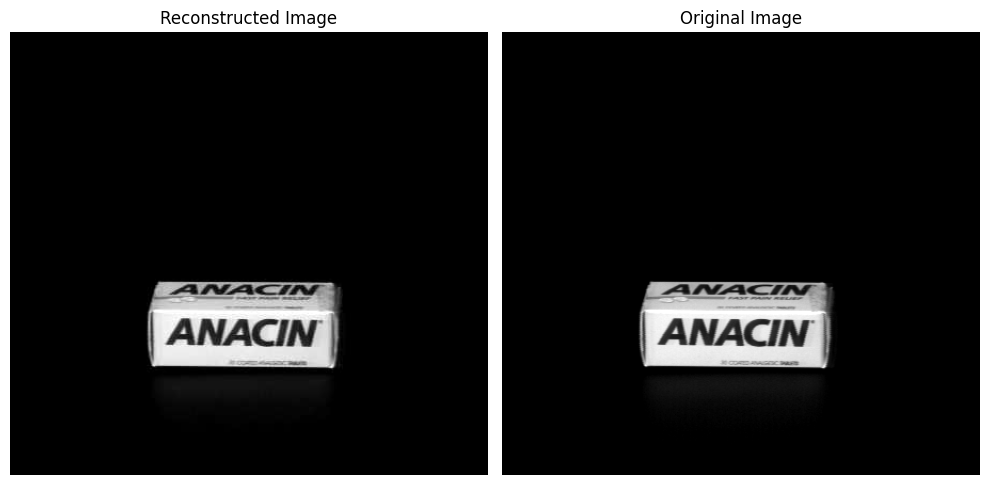

1.6481846047742454

In [345]:
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                         [12, 12, 14, 19, 26, 58, 60, 55], 
                         [14, 13, 16, 24, 40, 57, 69, 56], 
                         [14, 17, 22, 29, 51, 87, 80, 62], 
                         [18, 22, 37, 56, 68, 109, 103, 77], 
                         [24, 35, 55, 64, 81, 104, 113, 92], 
                         [49, 64, 78, 87, 103, 121, 120, 101], 
                         [72, 92, 95, 98, 112, 100, 103, 99]]).astype(np.uint16)

image, sz = image_process("coil-20-unproc/obj2__0.png")
image_org = np.array(Image.open("coil-20-unproc/obj2__0.png"))
dct_mat = compute_dct_mat(image, quant_matrix)

encoding, hufftable = encode(dct_mat)

# print(os.path.getsize("coil-20-unproc/obj1__0.png"))
# Writing to a file
write_compressed_file("compressed_image.dat", quant_matrix, hufftable, encoding, sz)
filename = "compressed_image.dat"
file_size = os.path.getsize(filename)
# print(f"Size of the file '{filename}': {file_size} bytes")

qmat, huffcodes, rle, sz = read_compressed_file("compressed_image.dat")

dct_mat_mat = decode_rle_data(rle, huffcodes, sz)

idct_mat = compute_Idct_mat(dct_mat_mat, qmat)

recon_image = post_process(idct_mat)


# print(recon_image)
# print(image_org)
# print(image)
recon_image_crop = recon_image[:sz[0], :sz[1]]

# image_crop = image[:sz[0], :sz[1]]
# image1 = Image.fromarray(recon_image_crop)
# image2 = Image.fromarray(image_org)

# image1.show(title="recon")
# image2.show(title="original")


fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Two images side by side

# Show the reconstructed image
axes[0].imshow(recon_image_crop, cmap='gray')
axes[0].set_title("Reconstructed Image")
axes[0].axis('off')

# Show the original image
axes[1].imshow(image_org, cmap='gray')
axes[1].set_title("Original Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

np.sqrt(np.mean((image_org - recon_image_crop) ** 2))



In [346]:
def compress(input_image_path, output_image_path, Q_factor):
    quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                         [12, 12, 14, 19, 26, 58, 60, 55], 
                         [14, 13, 16, 24, 40, 57, 69, 56], 
                         [14, 17, 22, 29, 51, 87, 80, 62], 
                         [18, 22, 37, 56, 68, 109, 103, 77], 
                         [24, 35, 55, 64, 81, 104, 113, 92], 
                         [49, 64, 78, 87, 103, 121, 120, 101], 
                         [72, 92, 95, 98, 112, 100, 103, 99]])
    
    qmat = (quant_matrix*(50/Q_factor)).astype(np.uint16)
    
    image, sz = image_process(input_image_path)

    dct_mat = compute_dct_mat(image, qmat)

    encoding, hufftable = encode(dct_mat)

    write_compressed_file(output_image_path, qmat, hufftable, encoding, sz)

    fileSize = os.path.getsize(output_image_path) 
    
    return sz, fileSize, image


- Decompress image

In [347]:
def decompress(filename):
    qmat, huffcodes, rle, sz = read_compressed_file(filename)
    
    dct_mat = decode_rle_data(rle, huffcodes, sz)

    idct_mat = compute_Idct_mat(dct_mat, qmat)

    recon_image = post_process(idct_mat)

    return recon_image[:sz[0], :sz[1]]

- RSME BPP plot

In [348]:
def rmseVSbpp(filename):
    qfactor = [1, 25, 50, 75, 100]
    bpp = []
    rsme_list = []
    for q in qfactor:
        output_fnm = filename.split('.')[0] + f'Q{q}.ojpeg' 
        sz, fsz, img = compress(filename, output_fnm, q)
        img = ((img + 128).astype(np.uint8))[:sz[0], :sz[1]]
        bpp.append(fsz*8/(sz[0]*sz[1]))
        recon_img = decompress(output_fnm)
        rsme = np.sqrt( np.mean( (recon_img - img) ** 2 ) )
        rsme_list.append(rsme)

    plt.figure(figsize=(8, 6))
    plt.plot(bpp, rsme_list, marker='o', linestyle='-', color='b', label='RMSE vs BPP')
    
    
    plt.xlabel('Bits per Pixel (BPP)')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title('RMSE vs BPP')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()
    

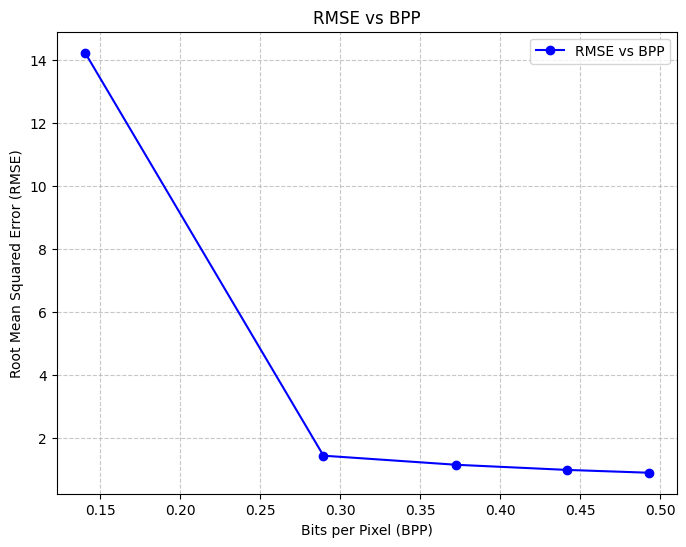

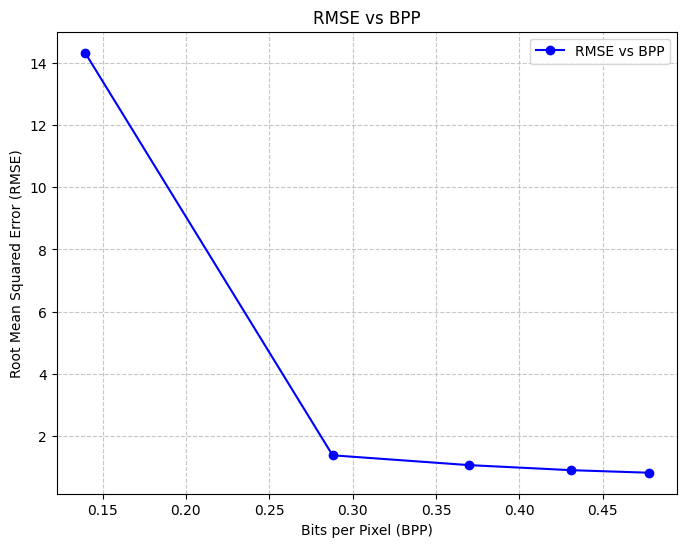

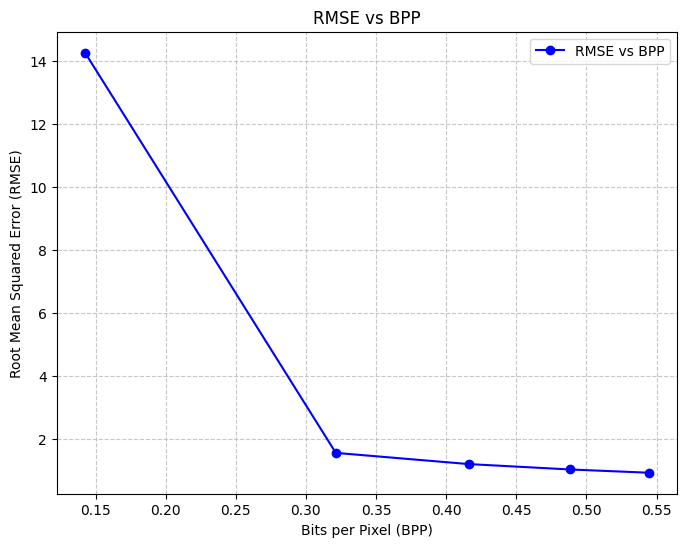

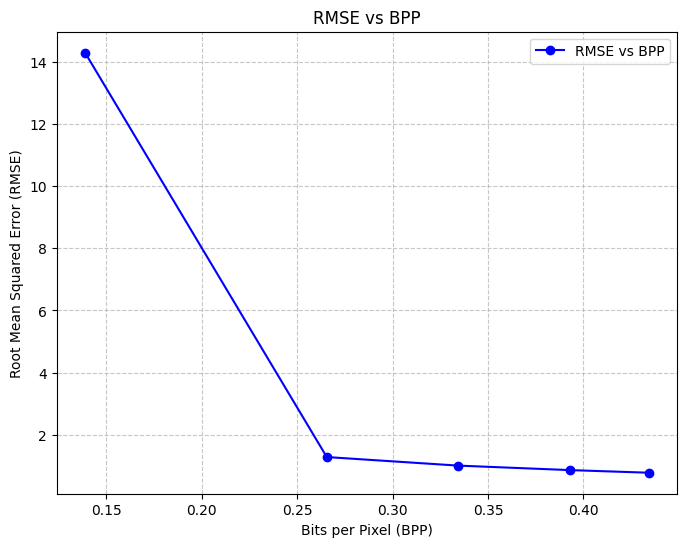

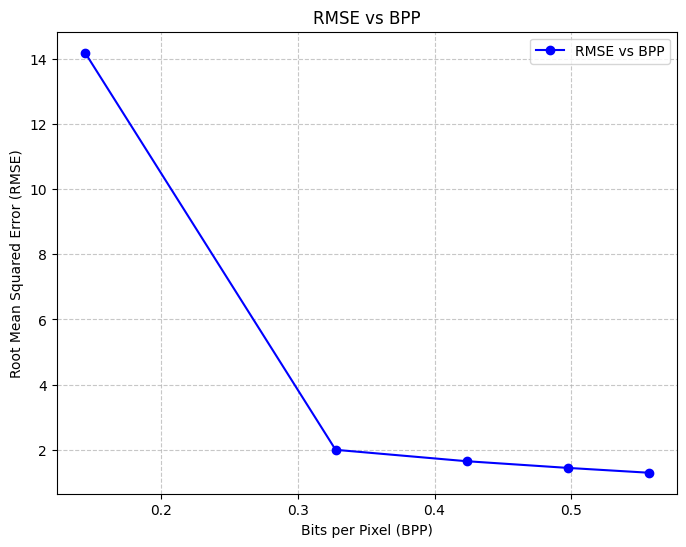

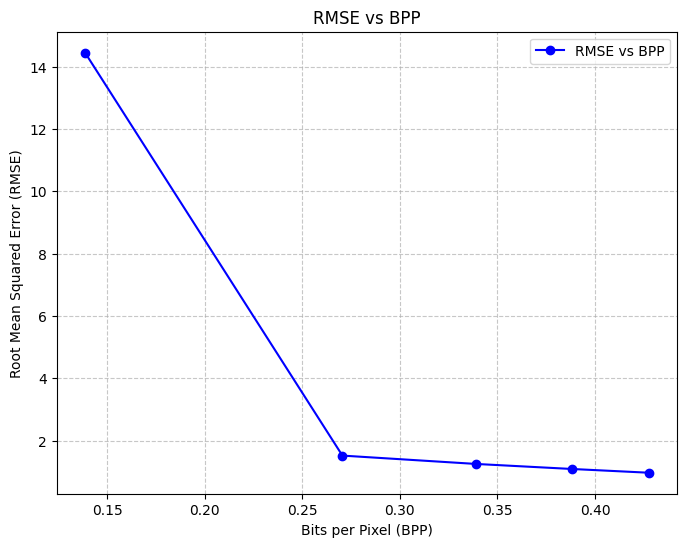

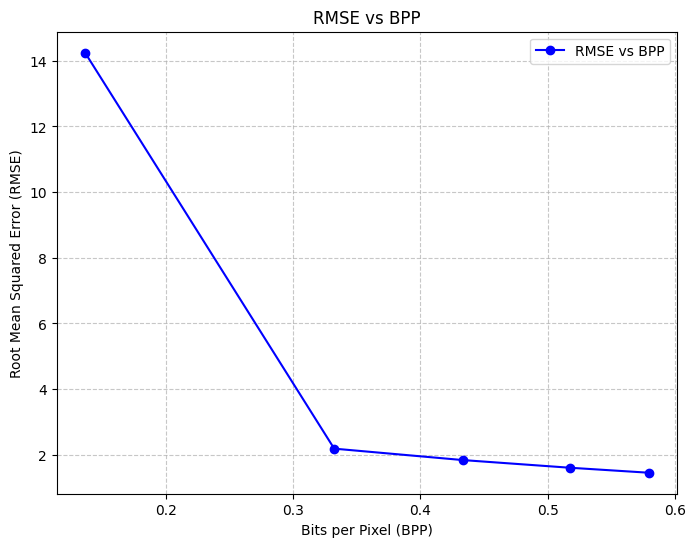

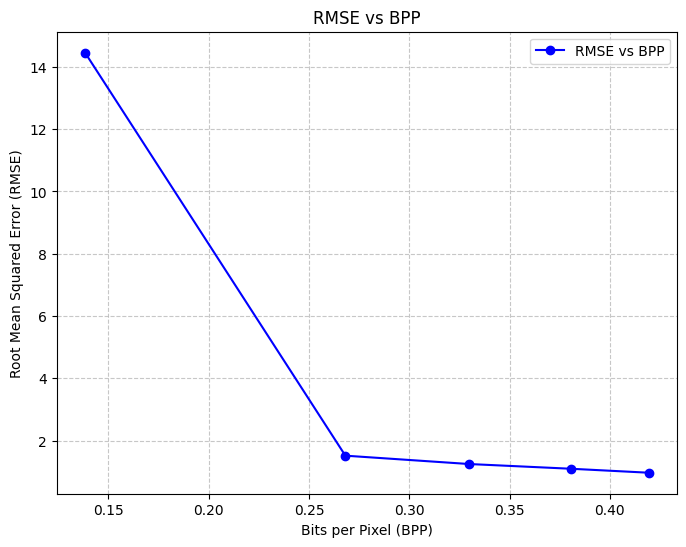

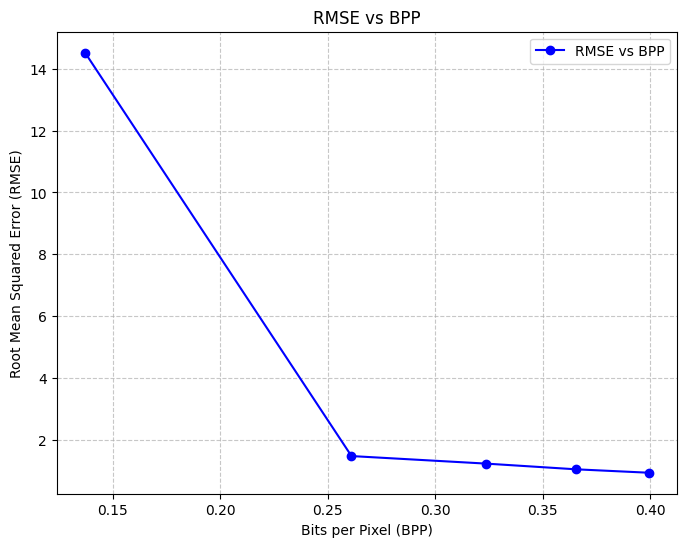

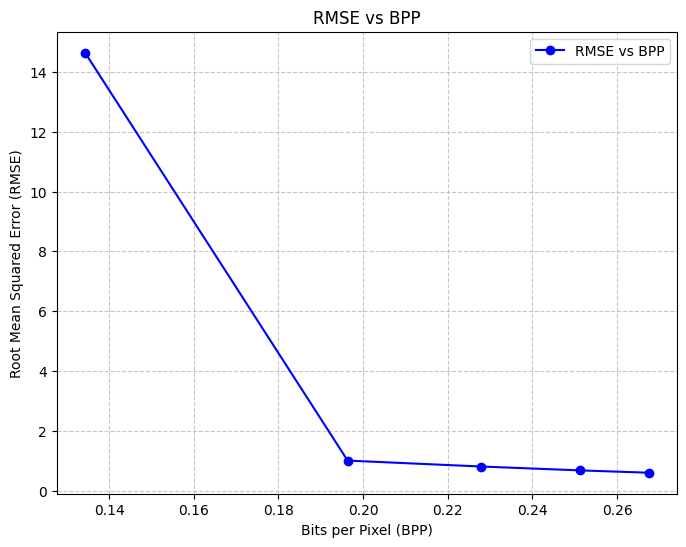

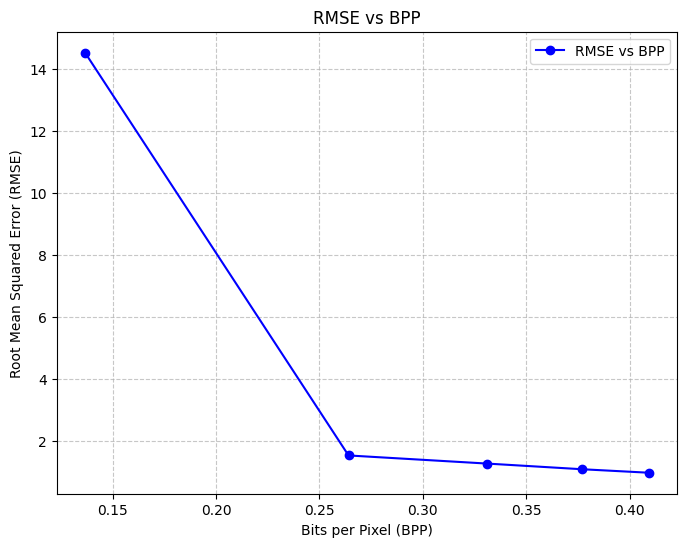

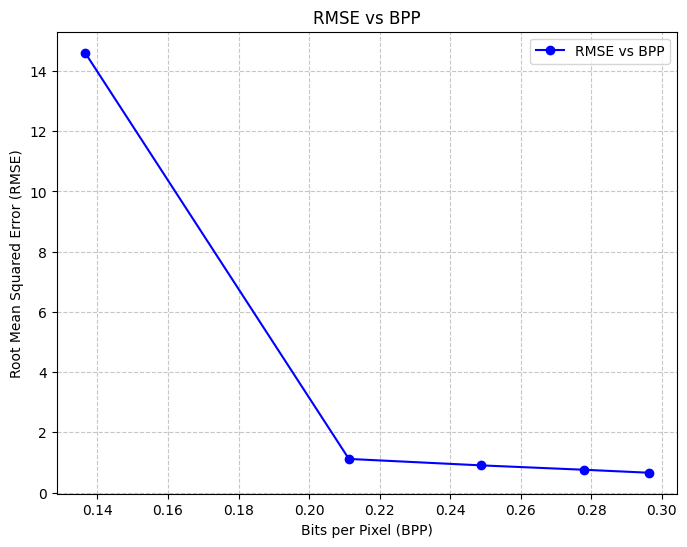

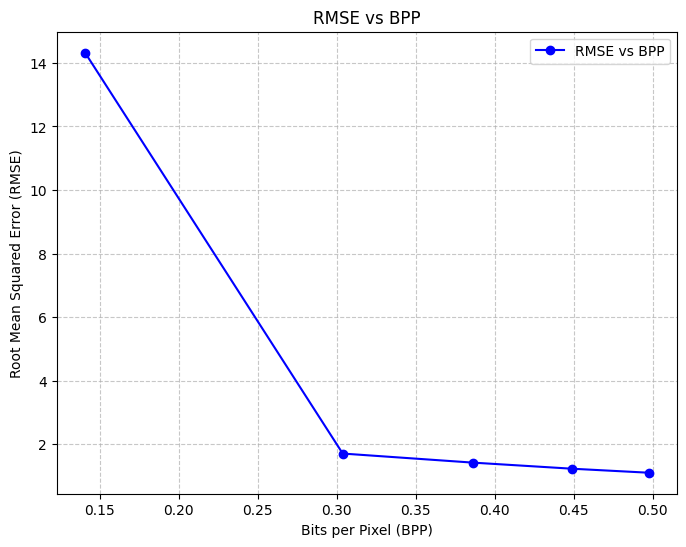

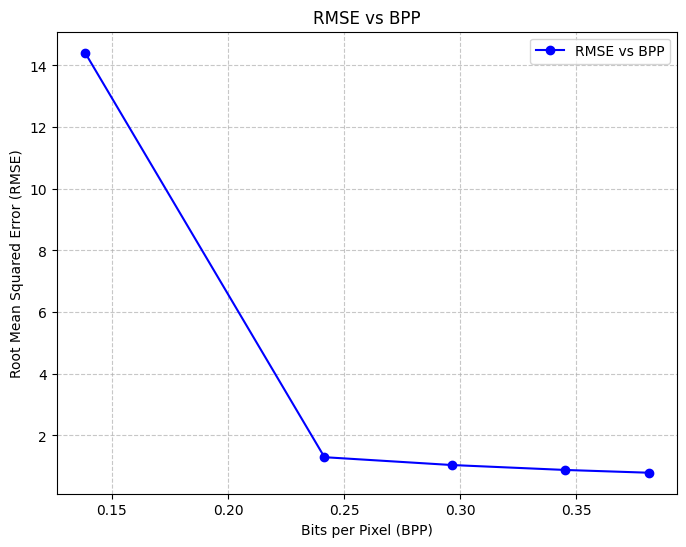

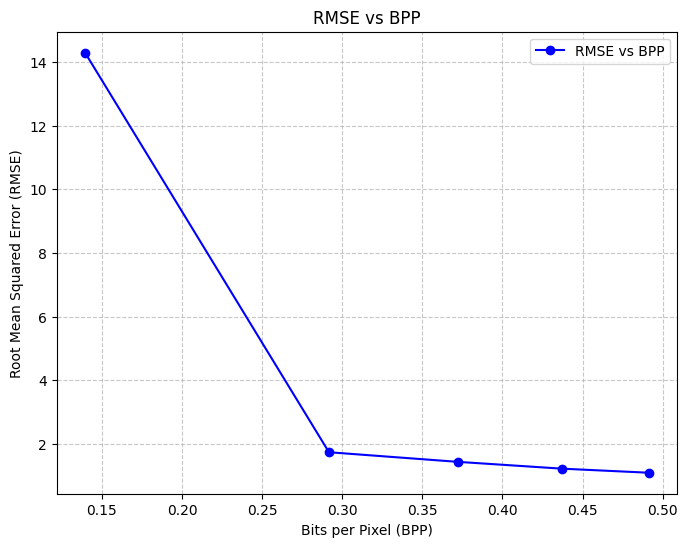

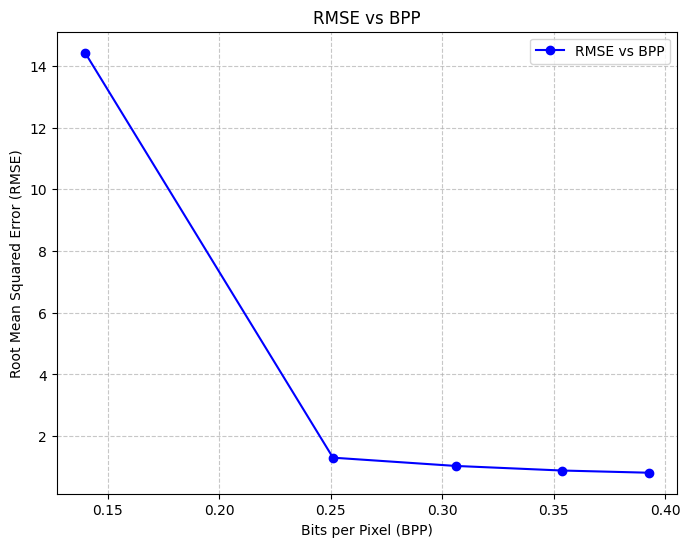

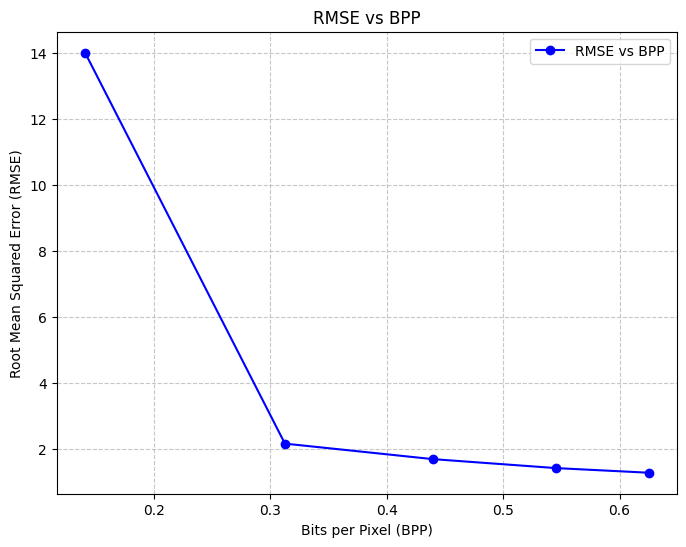

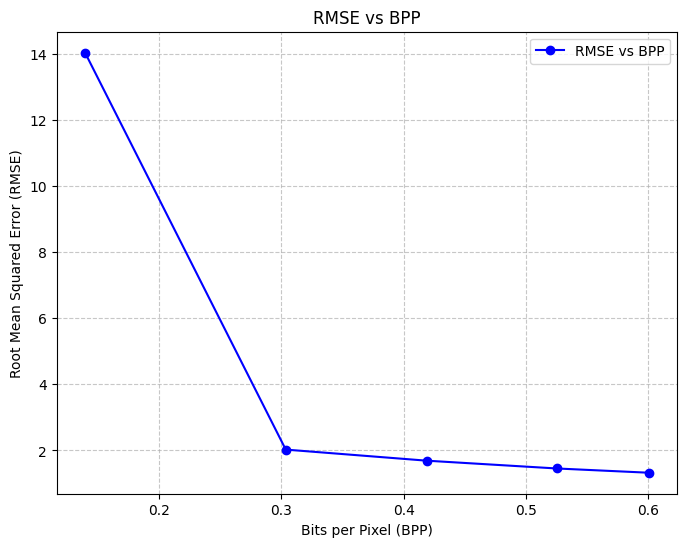

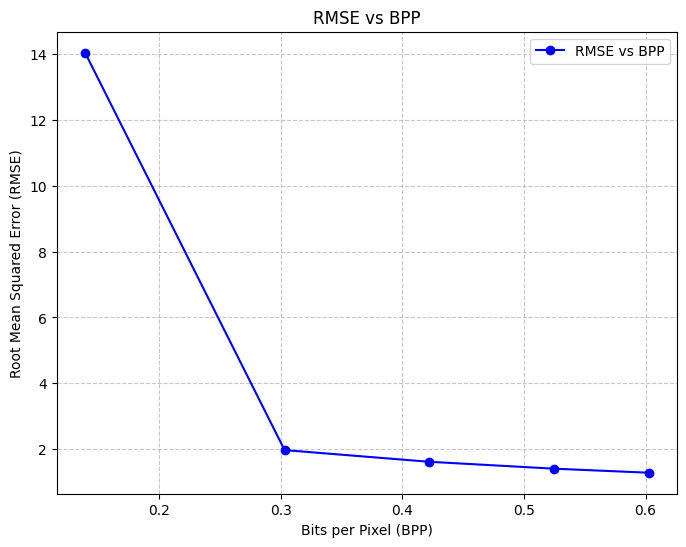

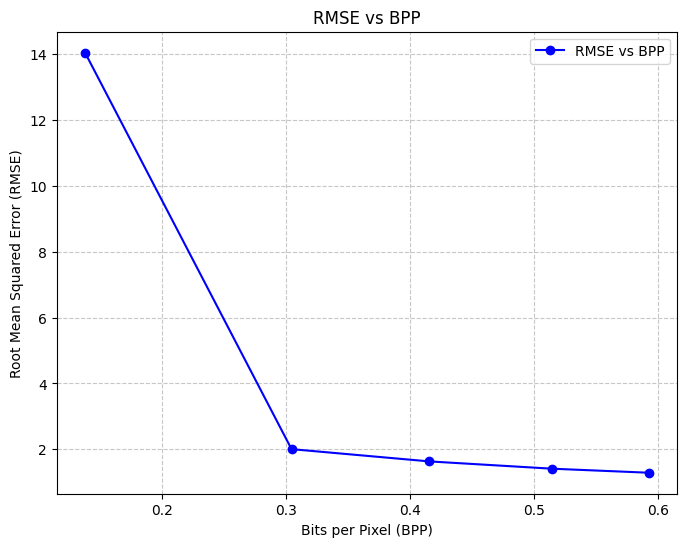

In [349]:
rmseVSbpp("coil-20-unproc/obj1__0.png")
rmseVSbpp("coil-20-unproc/obj1__18.png")
rmseVSbpp("coil-20-unproc/obj1__36.png")
rmseVSbpp("coil-20-unproc/obj1__54.png")
rmseVSbpp("coil-20-unproc/obj2__0.png")
rmseVSbpp("coil-20-unproc/obj2__18.png")
rmseVSbpp("coil-20-unproc/obj2__36.png")
rmseVSbpp("coil-20-unproc/obj2__54.png")
rmseVSbpp("coil-20-unproc/obj3__0.png")
rmseVSbpp("coil-20-unproc/obj3__18.png")
rmseVSbpp("coil-20-unproc/obj3__36.png")
rmseVSbpp("coil-20-unproc/obj3__54.png")
rmseVSbpp("coil-20-unproc/obj4__0.png")
rmseVSbpp("coil-20-unproc/obj4__18.png")
rmseVSbpp("coil-20-unproc/obj4__36.png")
rmseVSbpp("coil-20-unproc/obj4__54.png")
rmseVSbpp("coil-20-unproc/obj5__0.png")
rmseVSbpp("coil-20-unproc/obj5__18.png")
rmseVSbpp("coil-20-unproc/obj5__36.png")
rmseVSbpp("coil-20-unproc/obj5__54.png")